# A/B Testing from Scratch: Multi-armed Bandits

Frequentist and Bayesian A/B tests require you to divide your traffic into arbitrary groups for a period of time, then perform statistical tests based on the results. This 

In [350]:
import numpy as np
import pandas as pd

#widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

#plots
import matplotlib.pyplot as plt
from plotnine import *

#stats
import scipy as sp
import statsmodels as sm

In [351]:
class Arm:
    def __init__(self, true_p):
        self.true_p = true_p
        self.reset()
    def reset(self):
        self.impressions = 0
        self.actions = 0
    def get_state(self):
        return self.impressions,self.actions
    def get_rate(self):
        return self.actions / self.impressions if self.impressions >0 else 0.
    def pull(self):
        self.impressions+=1
        res = 1 if np.random.random() < self.true_p else 0
        self.actions+=res
        return res
a = Arm(0.1)
for i in range(100): a.pull()
a.get_state()

(100, 9)

In [43]:
class MusketeerEnv:
    def __init__(self, true_ps, avg_impressions):
        self.true_ps = true_ps
        self.avg_impressions = avg_impressions
        self.nb_arms = len(true_ps)
        self.reset()
    def reset(self):
        self.t = -1
        self.ds=[]
        self.arms = [Arm(p) for p in self.true_ps]
        return self.get_state()
    def get_state(self):
        return [self.arms[i].get_state() for i in range(self.nb_arms)]
    def get_rates(self):
        return [self.arms[i].get_rate() for i in range(self.nb_arms)]
    def get_impressions(self):
        return int(np.random.triangular(self.avg_impressions/2,
                                    self.avg_impressions,
                                    self.avg_impressions*1.5))
    def step(self, ps):
        self.t+=1
        impressions = self.get_impressions()
        for i in np.random.choice(a=self.nb_arms,size=impressions,p=ps):
            self.arms[i].pull()
        self.record()
        return self.get_state()
    def record(self):
        d = {'t':self.t,'max_rate':0,'opt_impressions':0}
        for i in range(self.nb_arms):
            d[f'impressions_{i}'],d[f'actions_{i}'] = self.arms[i].get_state()
            d[f'rate_{i}'] = self.arms[i].get_rate()
            if d[f'rate_{i}'] > d['max_rate']: 
                d['max_rate'] = d[f'rate_{i}']
                d['opt_impressions'] = d[f'impressions_{i}']
        d['total_impressions'] = sum([self.arms[i].impressions for i in range(self.nb_arms)])
        d['opt_impressions_rate'] = d['opt_impressions'] / d['total_impressions']
        d['total_actions'] = sum([self.arms[i].actions for i in range(self.nb_arms)])
        d['total_rate'] = d['total_actions'] / d['total_impressions']
        d['regret_rate'] = d['max_rate'] - d['total_rate']
        d['regret'] = d['regret_rate'] * d['total_impressions']
        self.ds.append(d)
    def show_df(self):
        df = pd.DataFrame(self.ds)
        cols = ['t'] + [f'rate_{i}' for i in range(self.nb_arms)]+ \
               [f'impressions_{i}' for i in range(self.nb_arms)]+ \
               [f'actions_{i}' for i in range(self.nb_arms)]+ \
               ['total_impressions','total_actions','total_rate']+ \
               ['opt_impressions','opt_impressions_rate']+ \
               ['regret_rate','regret']
        df = df[cols]
        return df

In [356]:
env = MusketeerEnv(true_ps = [0.1,0.12,0.13], avg_impressions=500)
for i in range(1000):
    env.step([0.6,0.2,0.2])
env.get_rates()

[0.09985756280874018, 0.12183649265282329, 0.1307769827673083]

In [357]:
env.show_df().head()

,t,rate_0,rate_1,rate_2,impressions_0,impressions_1,impressions_2,actions_0,actions_1,actions_2,total_impressions,total_actions,total_rate,opt_impressions,opt_impressions_rate,regret_rate,regret
0,0,0.124590,0.108911,0.182796,305,101,93,38,11,17,499,66,0.132265,93,0.186373,0.050531,25.215054
1,1,0.095023,0.105023,0.154930,663,219,213,63,23,33,1095,119,0.108676,213,0.194521,0.046254,50.647887
2,2,0.087284,0.108108,0.138514,928,296,296,81,32,41,1520,154,0.101316,296,0.194737,0.037198,56.540541
3,3,0.087322,0.107692,0.133690,1191,390,374,104,42,50,1955,196,0.100256,374,0.191304,0.033434,65.363636
4,4,0.092566,0.111359,0.134434,1372,449,424,127,50,57,2245,234,0.104232,424,0.188864,0.030202,67.804245


In [716]:
class BanditAgent:
    def __init__(self):
        pass
    
    #baselines
    def equal_weights(self,state):
        res = np.array([1/len(state) for i in range(len(state))])
        return res
    def randomize(self,state):
        res = np.random.rand(len(state))
        res /= res.sum()
        return res
    
    #stochastic policies
    def eps_greedy(self, state, t, start_eps=0.3, end_eps=0.01, gamma=0.99):
        eps = max(end_eps,start_eps * gamma**t)
        res = np.array([eps/len(state) for i in range(len(state))])
        best_idx = np.argmax([i[1]/i[0] for i in state]) if t > 0 else np.random.choice(range(len(state)))
        res[best_idx] += 1-eps
        return res
    def softmax(self, state, t, start_tau=1e-1, end_tau=1e-4, gamma=0.9):
        tau = max(end_tau,start_tau*gamma**t)
        sum_exp = sum([np.exp(i[1]/(i[0]+1e6)/tau) for i in state])
        res = np.array([np.exp(i[1]/(i[0]+1e6)/tau) / sum_exp for i in state])
        return res
    
    #deterministic policies
    def ucb(self, state, t):
        res = [(i[1]/i[0] + np.sqrt(2*np.log(t+1)/i[0])) for i in state]
        res = np.array(res)
        res_d = np.zeros(len(state))
        res_d[np.argmax(res)] = 1
        return res_d
    def thompson_deterministic(self, state):
        res = [np.random.beta(i[1]+1,i[0]-i[1]+1) for i in state]
        res = np.array(res)
        res_d = np.zeros(len(state))
        res_d[np.argmax(res)] = 1
        return res_d
    
    #thompsons
    def thompson_one(self,state):
        res = [np.random.beta(i[1]+1,i[0]-i[1]+1) for i in state]
        res = np.array(res)
        return res
    def thompson_stochastic(self,state,n=1000):
        l = []
        for i in range(n): l.append(self.thompson_one(state)[None,:])
        l = np.concatenate(l,0)
        is_max = l.max(1)[:,None] == l
        return is_max.mean(0)
    
env = MusketeerEnv(true_ps = [0.1,0.11,0.12], avg_impressions=500)
a = BanditAgent()
for i in range(1000):
    p = a.equal_weights(env.get_state())
    env.step(p)
    t=i
a.equal_weights(env.get_state()), a.randomize(env.get_state()), a.eps_greedy(env.get_state(),t),\
a.softmax(env.get_state(),t), a.thompson_stochastic(env.get_state()), \
a.ucb(env.get_state(),t), a.thompson_deterministic(env.get_state())

(array([0.33333333, 0.33333333, 0.33333333]),
 array([0.89832148, 0.01201857, 0.08965995]),
 array([0.00333333, 0.00333333, 0.99333333]),
 array([6.01771419e-13, 1.10757725e-05, 9.99988924e-01]),
 array([0., 0., 1.]),
 array([0., 0., 1.]),
 array([0., 0., 1.]))

In [712]:
env = MusketeerEnv(true_ps = [0.12,0.13,0.14], avg_impressions=400)
a = BanditAgent()
for t in range(200):
    state = env.get_state()
    action = a.thompson_stochastic(state)
    env.step(action)
df = env.show_df()

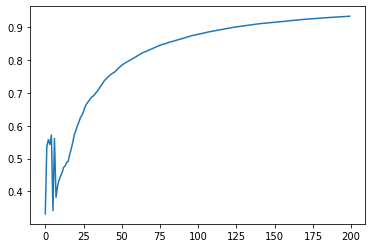

In [714]:
plt.plot(df.opt_impressions_rate)

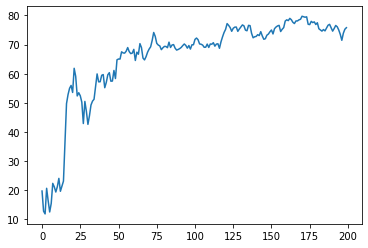

In [715]:
plt.plot(df.regret)